Quickstart: fitting with PCA
===========

To get started compressing opacities, we'll need to read in an opacity file. For the purposes of this tutorial,
we'll just use a small sample file.

First, let's import our package.

## Setting up the objects

In [5]:
import numpy as np

import cortecs
from cortecs.opac.opac import *
from cortecs.fit.fit import *
from cortecs.fit.fit_pca import *
from cortecs.eval.eval import *
from cortecs.fit.metrics import *

Next, let's define our filenames. The loader for `PLATON`-style opacity files is the only one that requires separate temperature, pressure, and wavelength files; no other file type requires the `load_kwargs` argument.

In [6]:
T_filename = "temperatures.npy"
P_filename = "pressures.npy"
wl_filename = "wavelengths.npy"

cross_sec_filename = "absorb_coeffs_C2H4.npy"

load_kwargs = {
    "T_filename": T_filename,
    "P_filename": P_filename,
    "wl_filename": wl_filename,
}

With our file names defined, we can instantiate an `Opac` object as below.

In [7]:
opac_obj = Opac(cross_sec_filename, loader="platon", load_kwargs=load_kwargs)

opac_obj

Now we have an `Opac` object instantiated. The object stores information on the opacity file's fields. Let's investigate a few.

In [8]:
opac_obj.wl  # these wavelengths are in meters

array([3.00000000e-07, 3.00299510e-07, 3.00599320e-07, ...,
       2.99401875e-05, 2.99700788e-05, 3.00000000e-05])

In [9]:
opac_obj.T  # these temperatures are in Kelvin

array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800.,
       1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700.,
       2800., 2900., 3000.])

In [10]:
opac_obj.P  # these pressures are in pascals

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08])

The wavelengths, temperatures, and pressures on which these opacities were evaluated are attributes of the `Opac` object.

## Fitting the opacity

Now, let's do something interesting with the `Opac` object: compress it using the principal components algorithm (PCA). This process works by first finding the vectors that best describe the shape of the temperature--pressure dependence of the opacity function at a *single wavelength*. Then, the code fits these eigenvectors to the temperature--pressure dependence of every other wavelength.

To do so, we'll instantiate the `Fitter` object. We pass `nc=5` to the `Fitter` object to tell it to use 3 eigenvectors to fit the opacity. This is a hyperparameter that you can tune to your liking. Increasing `nc` can provide a better fit, but doing so will take up more RAM. Decreasing `nc` may yield a worse opacity fit, but it will consume less memory.

We'll also pass `wav_ind=-2` to tell the `Fitter` object to fit the opacity at the first wavelength. This is the wavelength at which the eigenvectors are calculated. 

In [11]:
fitter = Fitter(opac_obj, wav_ind=-2, nc=5)
fitter

Again, the temperature--pressure dependence at all wavelengths is fitted as a linear combination of the eigenvectors calculated at `wav_ind`. The success of this approach can then of course depend on which`wav_ind` is chosen by the user. See the [optimizing fits notebook](https://cortecs.readthedocs.io/en/latest/pages/optimizing) for more information on how to choose the best `wav_ind`.

With our `Fitter` object set up, we can fit this serially. 

In [12]:
fitter.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4616/4616 [00:00<00:00, 25651.91it/s]


This process should be pretty quick — less than a second, hopefully. 

One thing to keep in mind is that the opacity values at the fitted wavelength shouldn't be constant unless the opacity values at *every* wavelength is constant. The first step of the fitting function is to find the PCA components that describe the temperature--pressure dependence of the wavelength at `wav_ind`. Afterward, it fits these components to the opacity values at each wavelength. Therefore, the temperature--pressure dependence at `wav_ind` should be at least somewhat representative of the temperature--pressure dependence everywhere.  

What do we do next? Now that we've *fit* the opacity, we can *evaluate* it. Hopefully things line up well enough.

We define our last object: an `Evaluator`. This step should look pretty similar as before.

In [13]:
evaluator = Evaluator(opac_obj, fitter)

# Saving fits to disk
Now that we've performed our fits, we can save them to disk for later evaluation. We'll use the `fitter` object and provide the `savename` argument for the base of the file names.

In [14]:
fitter.save("test_pca")

The two files `test_pca_coeffs.npy` and `test_pca_vectors.npy` have now been created. Great!

# Loading fits from disk
Loading the PCA fits is as easy as:

In [13]:
pca_coeffs = np.load("test_pca_coeffs.npz")["pca_coeffs"]
vectors = np.load("test_pca_vectors.npy")["vectors"]

# Evaluating the fits
If you're doing the fitting and evaluating on the same machine, it's convenient to use the `Eval` object defined above to "decompress" the compressed opacities.

However, a more common workflow involves evaluating the opacities on a different machine (e.g., a supercomputing cluster) or a different Python instance. To "decompress" our opacity, we can use the `eval_pca` method. It takes in the desired temperature, pressure, and wavelength at which to evaluate the opacity, the temperature, pressure, and wavelength arrays of the original data, and the results of our earlier fitting step. 

In [15]:
temperature = 500  # Kelvin — same as the original data
pressure = 1  # Pascals — same as the original data
wavelength = 1e-5  # meters — same as the original data

fitting_results = [vectors, pca_coeffs]
cortecs.eval.eval_pca.eval_pca(
    tempertaure,
    pressure,
    wavelength,
    opac_obj.T,
    opac_obj.P,
    opac_obj.wl,
    fitting_results,
)

Array(-29.885494, dtype=float32)

Oftentimes, radiative transfer calculations can be parallelized over wavelength. We provide an accelerator-friendly `JAX` implementation of 
this at a single wavelength.

In [18]:
pca_coeffs_single_wavelength = pca_coeffs[0]
temperature_ind = 1
pressure_ind = 2

eval_pca_ind_wav(temperature_ind, pressure_ind, vectors, pca_coeffs_single_wavelength)

Array(-104., dtype=float32)

## Checking accuracy and speed

Saving memory isn't all that useful if we're slow and inaccurate. Let's check whether that's the case.

First of all, time. Let's use a lower-level routine that's a bit more apples-to-apples comparison with array-indexing.

In [11]:
temperature_ind = np.where(np.isclose(opac_obj.T, temperature))[0][0]
pressure_ind = np.where(np.isclose(opac_obj.P, pressure))[0][0]
wavelength_ind = np.where(np.isclose(opac_obj.wl, wavelength))[0][0]
pca_vectors, pca_coeffs_all_wl = evaluator.fitter_results
pca_coeffs = pca_coeffs_all_wl[wavelength_ind, :, :]

In [12]:
%%timeit
eval_pca_ind_wav(temperature_ind, pressure_ind, pca_vectors, pca_coeffs)

7.78 µs ± 418 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Let's compare this to how long it takes to access an array.

In [13]:
%%timeit
opac_obj.cross_section[temperature_ind][pressure_ind][wavelength_ind]

263 ns ± 7.96 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Accessing the array directly is clearly faster. As long as this step does not bottleneck your code, however, you should be fine.

Now, let's check the accuracy. We'll compare the log abundances, because this is the quantity to which we are sensitive in exoplanet spectroscopy.

In [14]:
AMU = 1.6605390666e-24  # atomic mass unit in cgs. From astropy!

In [15]:
array_res = opac_obj.cross_section[temperature_ind][pressure_ind][wavelength_ind]

In [16]:
eval_res = np.log10(
    evaluator.eval(temperature, pressure, wavelength)
    * evaluator.load_obj.species_weight
    * AMU
    * 1e-4
)

In [17]:
percent_error = 100 * (eval_res - array_res) / array_res
percent_error

8.883276035105363

In [18]:
percent_error = 100 * (eval_res - array_res) / array_res
percent_error

8.883276035105363

We're reaching a 9% error in the log abundance. That might be good enough for your applications, or it might not. We recommend tuning your algorithm to the level of agreement necessary for, e.g., generating a transmission spectrum, or running an emission spectrum retrieval.

How do we do over the entire opacity function, as opposed to just a single point? Let's use the `metrics` module to find out.

We'll undersample the pressure and temperature axes by a factor of 2 using `tp_undersample_factor=2`. This is purely for computational reasons to keep the notebook a bit shorter.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]


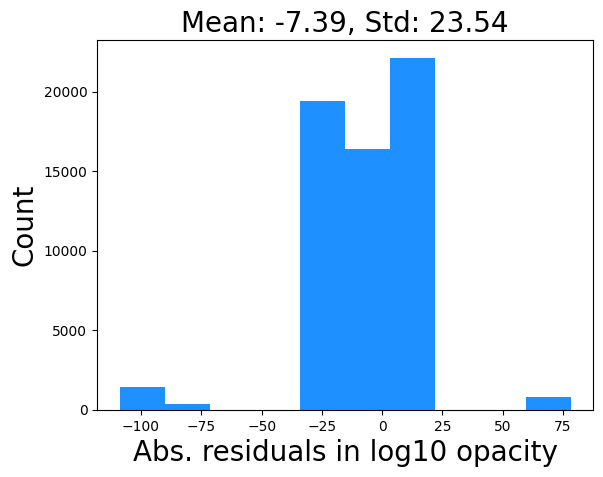

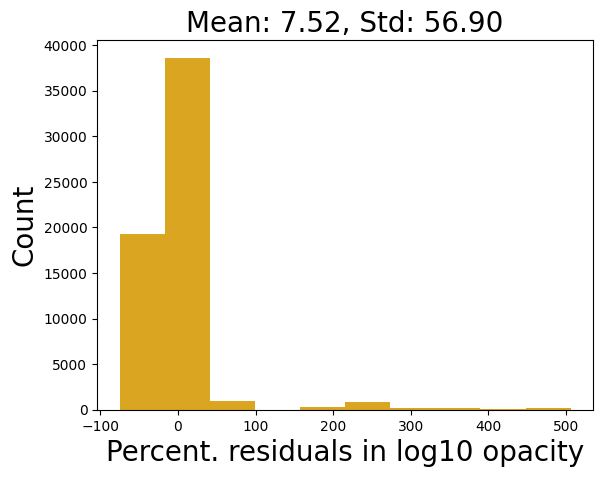

In [19]:
vals, orig_vals, abs_diffs, percent_diffs = calc_metrics(
    opac_obj, fitter, tp_undersample_factor=2, plot=True
);

Note that there's a distribution of accuracy. ***Ensure that this level of accuracy is adequate for your use case (e.g., run a test retrieval with and without cortecs) before applying `cortecs` to all your work!***